# Experiments for Graph Matching
This notebook contains the experiments to compare the graph matching results via embeddings produced by a GNN to graph matching results via embeddings that are represented by temporal centralities. 

In [ ]:
import numpy as np

In [2]:
source_node_order = ['carts', 'user', 'user-db', 'catalogue', 'catalogue-db', 'orders-db', 'carts-db', 'queue-master', 'rabbitmq', 'session-db', 'master', 'worker1', 'worker2', 'front-end', 'orders', 'shipping', 'payment']
target_node_order = ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db', 'worker1', 'worker2', 'master']
target_node_order_as_source_permutation = [source_node_order.index(node) for node in target_node_order]

In [2]:
temporal_betweenness_vectors_sources = np.load('../data/temporal_betweenness_vectors_overtime.npy')[:,target_node_order_as_source_permutation]
temporal_closeness_vectors_sources = np.load('../data/temporal_closeness_vectors_overtime.npy')[:,target_node_order_as_source_permutation]
temporal_degree_vectors_sources = np.load('../data/temporal_degree_vectors_overtime.npy')[:,target_node_order_as_source_permutation]

In [3]:
temporal_betweenness_vectors_targets = np.load('artificial-graph-generation/generated/temporal_betweennesses_unique.npy')
temporal_closeness_vectors_targets = np.load('artificial-graph-generation/generated/temporal_closenesses_unique.npy')
temporal_degree_vectors_targets = np.load('artificial-graph-generation/generated/temporal_degrees_unique.npy')

In [4]:
source_encodings = np.load("../data/anomaly_source_embeddings_17_dims_30_epochs.npy")
target_encodings = np.load("../data/anomaly_target_embeddings_17_dims_30_epochs.npy")

In [6]:
num_sources = len(temporal_betweenness_vectors_sources)
assert len(temporal_closeness_vectors_sources) == len(temporal_degree_vectors_sources) and len(temporal_closeness_vectors_sources) == num_sources
num_targets = len(temporal_betweenness_vectors_targets)
assert len(temporal_closeness_vectors_targets) == len(temporal_degree_vectors_targets) and len(temporal_closeness_vectors_targets) == num_targets


## Comparison of GNN to temporal betweenness

In [7]:
from scipy.spatial import distance
from tqdm import tqdm
from sklearn.metrics import dcg_score
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

In [8]:
# Temporal closeness
temporal_closeness_distances = []
temporal_closeness_rankings = []
for i in tqdm(range(num_sources)):
    temporal_closeness_distances.append([])
    for j in range(num_targets):
        temporal_closeness_distances[-1].append(distance.euclidean(temporal_betweenness_vectors_sources[i], temporal_betweenness_vectors_targets[j]))
    temporal_closeness_rankings.append(np.argsort(temporal_closeness_distances[-1]))

# Embeddings
embedding_distances = []
embedding_rankings = []
for i in tqdm(source_indices):
    embedding_distances.append([])
    for j in range(num_targets):
        embedding_distances[-1].append(distance.euclidean(source_encodings[i], target_encodings[j]))
    argsorted = np.argsort(embedding_distances[-1])
    result = np.arange(num_targets)
    for index in range(num_targets):
        result[argsorted[index]] = index
    embedding_rankings.append(result)
embedding_distances = np.array(embedding_distances, dtype=np.float32)
embedding_rankings = np.array(embedding_rankings, dtype=np.int32)
with gzip.open("embedding_distances.npy", "wb") as filehandle:
    np.save(filehandle, embedding_distances)
with gzip.open("embedding_rankings.npy", "wb") as filehandle:
    np.save(filehandle, embedding_rankings)

  0%|          | 2/18312 [05:56<907:45:07, 178.48s/it]

: 

: 

100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


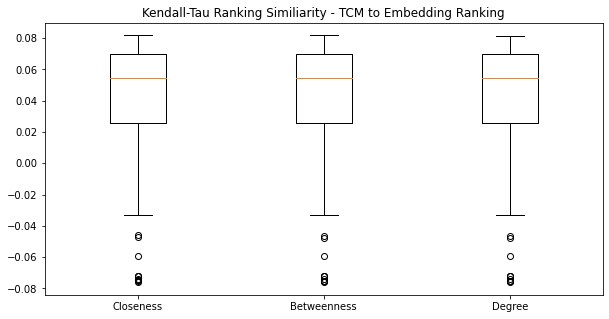

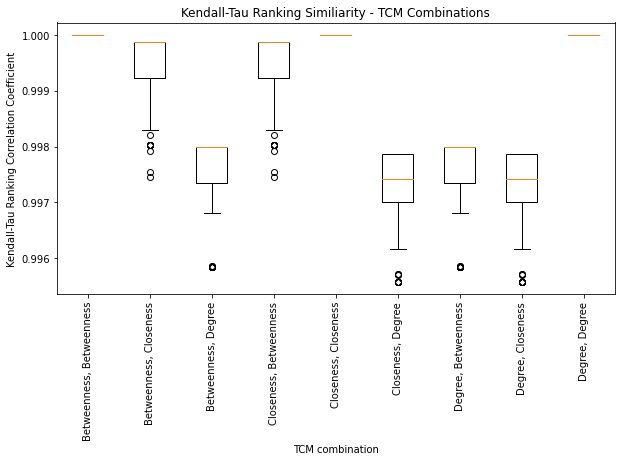

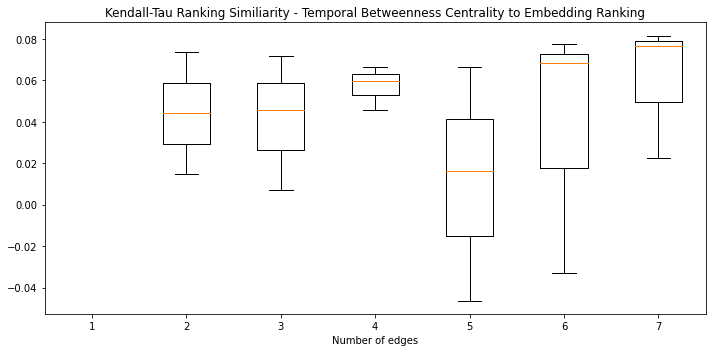

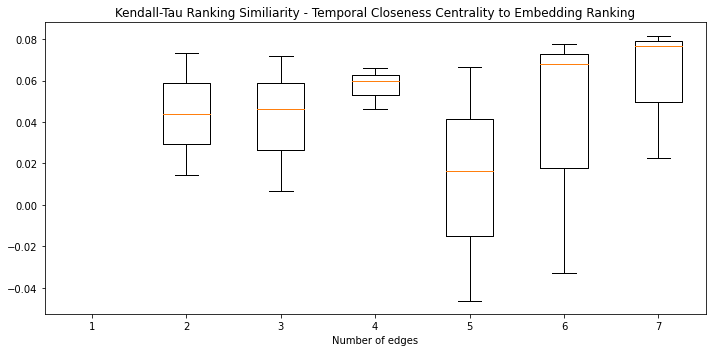

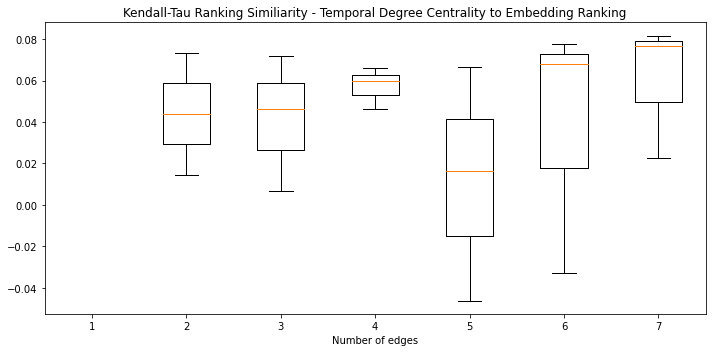

In [70]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from tqdm import tqdm
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score
from scipy.stats import kendalltau
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import gzip

source_sizes = np.load("../data/source_graph_num_edges.npy")
target_sizes = np.load("../data/target_graph_num_edges.npy")

def plot_by_size(scores, name):
    source_sizes_indices = source_sizes[source_sizes.argsort()]
    scores_sorted = scores[source_sizes.argsort()]
    unique_sizes = np.unique(source_sizes_indices, return_index=True)
    splitted = np.split(scores_sorted, unique_sizes[1])
    plt.figure(figsize=(10,5))
    plt.boxplot(splitted)
    plt.xlabel("Number of edges")
    plt.title(f"Kendall-Tau Ranking Similiarity - Temporal {name} Centrality to Embedding Ranking")
    plt.tight_layout()
    plt.savefig(f"KendallTau{name}EmbeddingBySize.png", dpi=1000, transparent=True)

with gzip.open("embedding_rankings.npy", "rb") as filehandle:
    embedding_rankings = np.load(filehandle)

with gzip.open("temporal_closeness_rankings.npy", "rb") as filehandle:
    temporal_closeness_rankings = np.load(filehandle)
closeness_embedding_scores = np.zeros((len(source_indices)), dtype=np.float32)
closeness_embedding_pvalues = np.zeros((len(source_indices)), dtype=np.float32)
for i in tqdm(range(len(source_indices))):
    closeness_embedding_scores[i], closeness_embedding_pvalues[i]  = kendalltau(temporal_closeness_rankings[i], embedding_rankings[i])
del temporal_closeness_rankings

with gzip.open("temporal_betweenness_rankings.npy", "rb") as filehandle:
    temporal_betweenness_rankings = np.load(filehandle)
betweenness_embedding_scores = np.zeros((len(source_indices)), dtype=np.float32)
betweenness_embedding_pvalues = np.zeros((len(source_indices)), dtype=np.float32)
for i in tqdm(range(len(source_indices))):
    betweenness_embedding_scores[i], betweenness_embedding_pvalues[i] = kendalltau(temporal_betweenness_rankings[i], embedding_rankings[i])
del temporal_betweenness_rankings

with gzip.open("temporal_degree_rankings.npy", "rb") as filehandle:
    temporal_degree_rankings = np.load(filehandle)
degree_embedding_scores = np.zeros((len(source_indices)), dtype=np.float32)
degree_embedding_pvalues = np.zeros((len(source_indices)), dtype=np.float32)
for i in tqdm(range(len(source_indices))):
    degree_embedding_scores[i], degree_embedding_pvalues[i] = kendalltau(temporal_degree_rankings[i], embedding_rankings[i])
del temporal_degree_rankings

np.savez_compressed("ranking_scores.npz",
    closeness_embedding_scores=closeness_embedding_scores,
    closeness_embedding_pvalues=closeness_embedding_pvalues,
    betweenness_embedding_scores=betweenness_embedding_scores,
    betweenness_embedding_pvalues=betweenness_embedding_pvalues,
    degree_embedding_scores=degree_embedding_scores,
    degree_embedding_pvalues=degree_embedding_pvalues
)
del embedding_rankings
plt.figure(figsize=(10,5))
plt.boxplot([closeness_embedding_scores, betweenness_embedding_scores, degree_embedding_scores])
plt.xticks(list(range(1,4)), ["Closeness", "Betweenness", "Degree"])
plt.title("Kendall-Tau Ranking Similiarity - TCM to Embedding Ranking")
plt.savefig("EmbeddingRankingKendallTau.png", dpi=1000, transparent=True)

with gzip.open("temporal_closeness_rankings.npy", "rb") as filehandle:
    temporal_closeness_rankings = np.load(filehandle)
with gzip.open("temporal_betweenness_rankings.npy", "rb") as filehandle:
    temporal_betweenness_rankings = np.load(filehandle)
with gzip.open("temporal_degree_rankings.npy", "rb") as filehandle:
    temporal_degree_rankings = np.load(filehandle)
ranking_combination_names = list(itertools.product(["Betweenness", "Closeness", "Degree"], ["Betweenness", "Closeness", "Degree"]))
ranking_combinations = list(itertools.product([temporal_betweenness_rankings, temporal_closeness_rankings, temporal_degree_rankings], [temporal_betweenness_rankings, temporal_closeness_rankings, temporal_degree_rankings]))
all_tcm_scores = [[kendalltau(a[i], b[i])[0] for i in range(len(source_indices))] for a,b in tqdm(ranking_combinations)]
plt.figure(figsize=(10,5))
plt.boxplot(all_tcm_scores)
plt.xlabel("TCM combination")
plt.ylabel("Kendall-Tau Ranking Correlation Coefficient")
plt.xticks(list(range(1,len(ranking_combination_names)+1)), list(map(lambda x: ", ".join(x), ranking_combination_names)), rotation=90)
plt.title("Kendall-Tau Ranking Similiarity - TCM Combinations")
plt.savefig("TCMRankingKendallTau.png", dpi=1000, transparent=True)

plot_by_size(betweenness_embedding_scores, "Betweenness")
plot_by_size(closeness_embedding_scores, "Closeness")
plot_by_size(closeness_embedding_scores, "Degree")

60317


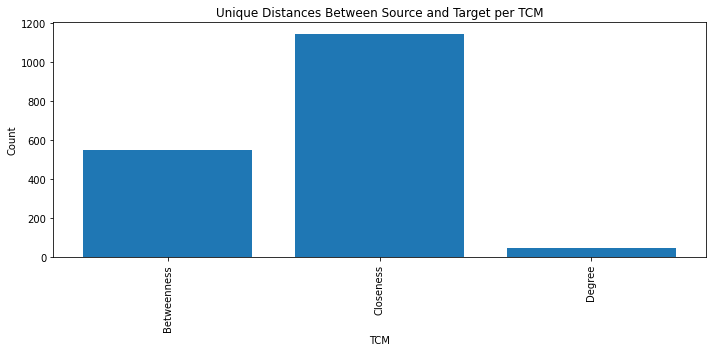

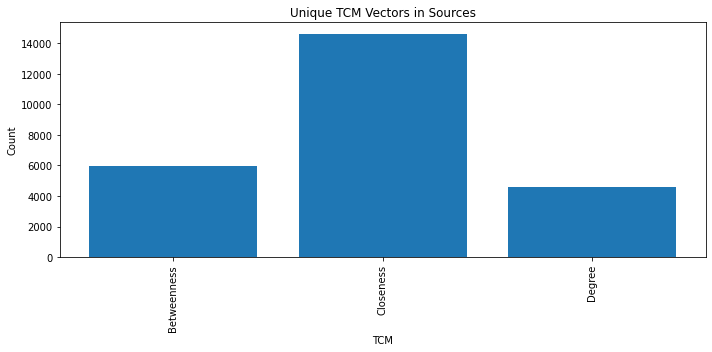

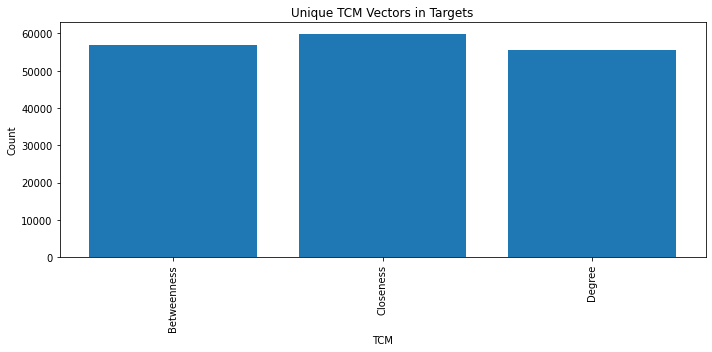

In [63]:
import gzip, numpy
import matplotlib.pyplot as plt
with gzip.open("temporal_closeness_distances.npy", "rb") as filehandle:
    temporal_closeness_distances = np.load(filehandle)
with gzip.open("temporal_betweenness_distances.npy", "rb") as filehandle:
    temporal_betweenness_distances = np.load(filehandle)
with gzip.open("temporal_degree_distances.npy", "rb") as filehandle:
    temporal_degree_distances = np.load(filehandle)
names = ["Betweenness", "Closeness", "Degree"]
uniques = [np.unique(el, return_counts=False, return_index=False, return_inverse=False).size for el in [temporal_betweenness_distances, temporal_closeness_distances, temporal_degree_distances]]
plt.figure(figsize=(10,5))
plt.bar(range(len(uniques)), uniques)
plt.xlabel("TCM")
plt.ylabel("Count")
plt.xticks(list(range(0,len(names))), names, rotation=90)
plt.title("Unique Distances Between Source and Target per TCM")
plt.tight_layout()
plt.savefig("UniqueTCMSourceTarget.png", dpi=1000, transparent=True)

temporal_betweenness_vectors_sources = np.load('../data/temporal_betweenness_vectors_overtime.npy')
temporal_closeness_vectors_sources = np.load('../data/temporal_closeness_vectors_overtime.npy')
temporal_degree_vectors_sources = np.load('../data/temporal_degree_vectors_overtime.npy')
names = ["Betweenness", "Closeness", "Degree"]
uniques = [len(np.unique(el, return_counts=False, return_index=False, return_inverse=False, axis=0)) for el in [temporal_betweenness_vectors_sources, temporal_closeness_vectors_sources, temporal_degree_vectors_sources]]
plt.figure(figsize=(10,5))
plt.bar(range(len(uniques)), uniques)
plt.xlabel("TCM")
plt.ylabel("Count")
plt.xticks(list(range(0,len(names))), names, rotation=90)
plt.title("Unique TCM Vectors in Sources")
plt.tight_layout()
plt.savefig("UniqueTCMSource.png", dpi=1000, transparent=True)

temporal_betweenness_vectors_targets = np.load('artificial-graph-generation/generated/temporal_betweennesses_unique.npy')
temporal_closeness_vectors_targets = np.load('artificial-graph-generation/generated/temporal_closenesses_unique.npy')
temporal_degree_vectors_targets = np.load('artificial-graph-generation/generated/temporal_degrees_unique.npy')
print(temporal_betweenness_vectors_targets.shape[0])
names = ["Betweenness", "Closeness", "Degree"]
uniques = [len(np.unique(el, return_counts=False, return_index=False, return_inverse=False, axis=0)) for el in [temporal_betweenness_vectors_targets, temporal_closeness_vectors_targets, temporal_degree_vectors_targets]]
plt.figure(figsize=(10,5))
plt.bar(range(len(uniques)), uniques)
plt.xlabel("TCM")
plt.ylabel("Count")
plt.xticks(list(range(0,len(names))), names, rotation=90)
plt.title("Unique TCM Vectors in Targets")
plt.tight_layout()
plt.savefig("UniqueTCMTarget.png", dpi=1000, transparent=True)

100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


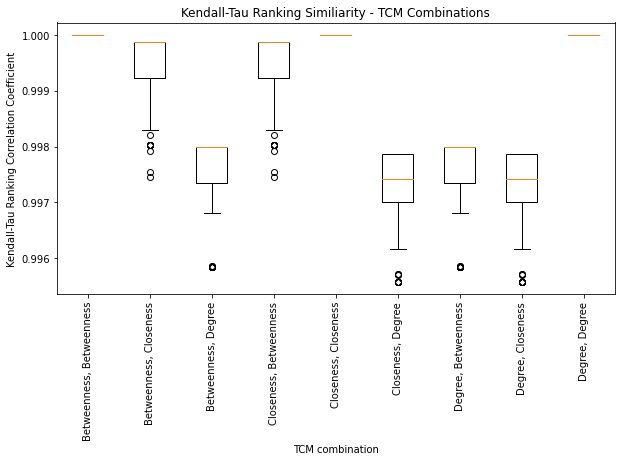

In [31]:
ranking_combination_names = list(itertools.product(["Betweenness", "Closeness", "Degree"], ["Betweenness", "Closeness", "Degree"]))
ranking_combinations = list(itertools.product([temporal_betweenness_rankings, temporal_closeness_rankings, temporal_degree_rankings], [temporal_betweenness_rankings, temporal_closeness_rankings, temporal_degree_rankings]))
all_tcm_scores = [[kendalltau(a[i], b[i])[0] for i in range(len(source_indices))] for a,b in tqdm(ranking_combinations)]
plt.figure(figsize=(10,5))
plt.boxplot(all_tcm_scores)
plt.xlabel("TCM combination")
plt.ylabel("Kendall-Tau Ranking Correlation Coefficient")
plt.xticks(list(range(1,len(ranking_combination_names)+1)), list(map(lambda x: ", ".join(x), ranking_combination_names)), rotation=90)
plt.title("Kendall-Tau Ranking Similiarity - TCM Combinations")
plt.savefig("TCMRankingKendallTau.svg", transparent=True)

In [73]:
betweenness_scores = []
for i in tqdm(range(len(source_indices))):
    betweenness_scores.append(kendalltau(temporal_betweenness_rankings[i], embedding_rankings[i]))

100%|██████████| 100/100 [00:02<00:00, 40.33it/s]


In [74]:
degree_scores = []
for i in tqdm(range(len(source_indices))):
    degree_scores.append(kendalltau(temporal_degree_rankings[i], embedding_rankings[i]))

100%|██████████| 100/100 [00:01<00:00, 50.68it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x16dcc3af0>,
 'caps': [<matplotlib.lines.Line2D at 0x16dcd00d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16dcc3820>,
 'medians': [<matplotlib.lines.Line2D at 0x16dcd0670>,
 'fliers': [<matplotlib.lines.Line2D at 0x16dcd0940>,
 'means': []}

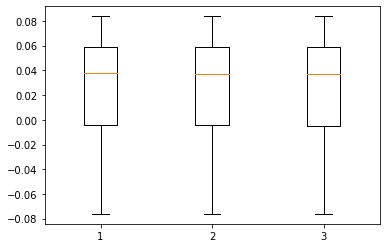

In [75]:
plt.boxplot([list(zip(*closeness_scores))[0], list(zip(*betweenness_scores))[0], list(zip(*degree_scores))[0]])
